# Семинар 5. Разреженные матрицы и графы. Примеры автоматического дифференцирования

## Графы и задачи для них

- Community detection
- Graph clustering

In [86]:
import networkx as nx
from networkx.algorithms import community

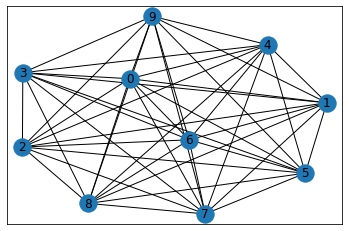

In [102]:
# G = nx.barbell_graph(5, 2)
# G = nx.lollipop_graph(10, 5)
G = nx.random_graphs.complete_graph(10)
nx.draw_networkx(G)

In [103]:
nx.adj_matrix(G).toarray()

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

In [93]:
communities_generator = community.girvan_newman(G)
for com in communities_generator:
    print(com)

({0, 1, 2, 3, 4, 5}, {6, 7, 8, 9, 10, 11})
({0, 1, 2, 3, 4}, {5}, {6, 7, 8, 9, 10, 11})
({0, 1, 2, 3, 4}, {5}, {6}, {7, 8, 9, 10, 11})
({0}, {1, 2, 3, 4}, {5}, {6}, {7, 8, 9, 10, 11})
({0}, {1}, {2, 3, 4}, {5}, {6}, {7, 8, 9, 10, 11})
({0}, {1}, {2}, {3, 4}, {5}, {6}, {7, 8, 9, 10, 11})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7, 8, 9, 10, 11})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8, 9, 10, 11})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9, 10, 11})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10, 11})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11})


In [94]:
nx.pagerank(G)

{0: 0.08480616898497634,
 1: 0.08480616898497634,
 2: 0.08480616898497634,
 3: 0.08480616898497634,
 4: 0.1073087699931968,
 5: 0.053466554066897876,
 6: 0.053466554066897876,
 7: 0.10730876999319683,
 8: 0.08480616898497634,
 9: 0.08480616898497634,
 10: 0.08480616898497634,
 11: 0.08480616898497632}

In [98]:
nx.shortest_path(G, 1, 10)

[1, 4, 5, 6, 7, 10]

## Автоматическое дифференцирование

- Основа обучения современных нейросетей
- Функция, которая предсказывает метку класса, задаётся как суперпозиция функций
- Каждый элемент суперпозиции оснащается дополнительно функцией вычисления градиента
- Используя правила дифференцирования сложной функции можно **автоматически** посчитать градиент исходной функции 

In [21]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

In [93]:
x = 1.2
print(jnp.sin(5 * x + 10))
print(jax.grad(lambda x: jnp.sin(5 * x + 10))(x), 5 * jnp.cos(5 * x + 10))
print(jax.grad(jax.grad(lambda x: jnp.sin(5 * x + 10)))(x), -25 * jnp.sin(5 * x + 10))

-0.2879033166650653
-4.788297401616923 -4.788297401616923
7.197582916626633 7.197582916626633


In [23]:
def f(x, A, b):
    z = A @ x - b
    return z @ z * 0.5

- Функция - евклидова норма невязки 

$$ \frac12 \|Ax - b\|_2^2$$
- Outer product $uv^{\top}$

In [24]:
import numpy as np
m = 10
n = 5
A = np.random.randn(m, n)
b = np.random.randn(m)
x = np.random.randn(n)

In [25]:
grad_func = jax.grad(f)
print(np.linalg.norm(A.T @ (A @ x - b) - grad_func(x, A, b)))

0.0


In [28]:
jax.grad(f, 1)(x, A, b).shape

(10, 5)

In [29]:
automatic_grad = jax.grad(f, 1)(x, A, b)
s = np.linalg.svd(automatic_grad, compute_uv=False)

In [31]:
np.linalg.norm(automatic_grad - np.outer(A @ x - b, x))

3.9282965365922575e-16

In [32]:
A = np.outer(np.random.randn(10), np.random.randn(15))
np.linalg.matrix_rank(A)

1

In [94]:
grad_trace = jax.grad(jnp.trace)(np.random.randn(5, 5))
grad_trace

DeviceArray([[1., 0., 0., 0., 0.],
             [0., 1., 0., 0., 0.],
             [0., 0., 1., 0., 0.],
             [0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 1.]], dtype=float64)

In [46]:
A = np.random.randn(15, 15)
def fro_norm(A):
    return jnp.sum(A**2)
grad_norm = jax.grad(fro_norm)(A)

In [47]:
grad_norm - 2 * A

DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0.,

In [70]:
def module(x):
    y = -x
    return jnp.max(jnp.array([x, y]))

jax.grad(module)(0.)

DeviceArray(0., dtype=float64)

In [71]:
jax.grad(jnp.abs)(0.)

DeviceArray(1., dtype=float64)

In [65]:
jax.grad(jnp.max)(jnp.array([1., 2., 3.]))

DeviceArray([0., 0., 1.], dtype=float64)

In [83]:
def func(x):
    return jnp.exp(x) / jnp.sum(jnp.exp(x))

In [87]:
func(np.random.randn(10) * 10)

DeviceArray([1.04749714e-10, 2.31664156e-02, 1.72381874e-09,
             9.73603759e-01, 1.38710512e-03, 1.76683599e-03,
             8.83132247e-08, 7.57909060e-05, 1.66637535e-11,
             3.16698532e-09], dtype=float64)

In [91]:
jax.jacobian(func)(np.random.randn(10))

DeviceArray([[ 0.07546917, -0.00924999, -0.01100041, -0.0043171 ,
              -0.0056508 , -0.00352245, -0.00095948, -0.01126796,
              -0.02464666, -0.00485431],
             [-0.00924999,  0.09983425, -0.01504797, -0.00590556,
              -0.00772999, -0.00481853, -0.00131252, -0.01541396,
              -0.0337153 , -0.00664043],
             [-0.01100041, -0.01504797,  0.11587873, -0.0070231 ,
              -0.00919277, -0.00573036, -0.00156089, -0.01833081,
              -0.0400954 , -0.00789703],
             [-0.0043171 , -0.00590556, -0.0070231 ,  0.0497434 ,
              -0.0036077 , -0.00224887, -0.00061257, -0.00719391,
              -0.0157354 , -0.00309918],
             [-0.0056508 , -0.00772999, -0.00919277, -0.0036077 ,
               0.06399631, -0.00294363, -0.00080181, -0.00941636,
              -0.02059661, -0.00405663],
             [-0.00352245, -0.00481853, -0.00573036, -0.00224887,
              -0.00294363,  0.04100109, -0.00049981, -0.00586973,
   